# Deep Learning &mdash; Assignment 3

Third assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:**
Daan Brugmans, Maximilian Pohl

**Group:**
31

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Experiment with convolutional neural networks
2. Train a convolutional neural network on a speech dataset
3. Investigate the effect of dropout and batch normalization
4. Define and train a residual neural network

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book,
* `python_speech_features` to compute MFCC features.

All libraries can be installed with `pip install`.

## 3.1 Convolution and receptive fields (9 points)

We will first define some helper functions to plot the receptive field of a node in a network.

Using these functions, we can define a network and plot the receptive field of a pixel in the output.

**(a) Run the code to define a network with one 3×3 convolution layer and plot the images.**

Read these images as follows:
* On the left, you see the input size of the network (here: 15 x 15 pixels) and the receptive field for one pixel in the output.
* On the right, you see the output size of the network (here: 13 x 13 pixels).

To visualize the receptive field of this network, we used the following procedure:
* We selected one pixel of the output (shown as the white pixel in the center in the image on the right).
* We computed the gradient for this pixel and plotted the gradient with respect to the input (the image on the left).
* This shows you the receptive field of the network: the output for the pixel we selected depends on these 9 pixels in the input.

**(b) Use this method to plot the receptive field of a pixel in the output of a convolution layer with a kernel size of 5×5.<span style="float:right"> (1 point)</span>**

If you look at the result, you will see that two things have changed: the receptive field and the output size.

**(c) How do the receptive field size and the output size depend on the kernel size? Give a formula.<span style="float:right"> (1 point)</span>**

### Counting the number of parameters

In the previous question, you saw how the receptive fields of a 3x3 convolution differs from a 5x5 kernel convolution. But this is not the only difference: there is also a difference in the number of parameters in the network.

We can count the number of parameters in the network by computing the number of elements (e.g., the weights and biases in a convolution kernel) in the parameter list of the PyTorch network.

We'll define a small helper function to do this:

In [ ]:
def print_parameter_count(network):
    # sum the number of elements in each parameter of the network
    count = sum([param.data.numel() for param in network.parameters()])
    print('%d parameters' % count)

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3)),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(e) Do the same to count the number of parameters for a 5x5 convolution.<span style="float:right"> (1 point)</span>**

**(f) Explain the results by showing how to _compute_ the number of parameters for the 3x3 and 5x5 convolutions.<span style="float:right"> (1 point)</span>**

Number of elements in the kernel + one bias

#params_5x5 = 5 * 5 + 1
#params_3x3 = 3 * 3 + 1

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(2, 3, kernel_size=(5, 5)),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(h) Show how to compute the number of parameters for this case.<span style="float:right"> (1 point)</span>**

### Preserving the size of the input image

The PyTorch documentation for [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) describes the parameters that you can use to define a convolutional layer. We will explore some of those parameters in the next questions.

In the previous plot, you may have noticed that the output (13x13 pixels) was slightly smaller than the input (15x15 pixels).

**(i) Define a network with a single 3x3 convolutional layer that produces an output that has the same size as the input.<span style="float:right"> (1 point)</span>**

Use 1 input and 1 output channel.

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(5, 5), padding=2),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

Play around with some other values to see how this parameter behaves.

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1),
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1),
)
print(net)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

Since we now have two layers, the visualization shows an extra image. From right to left, we have:
* Right: the output size and a single active pixel.
* Middle: the receptive field for the single output pixel between the first and second convolution.
* Left: the receptive field for the single output pixel in the input image.

One 5x5 convolution requires 26 parameters, while two 3x3 convolutions, resulting in the same receptive field, only require 20 parameters. This means, applying two 3x3 convolutions is more parameter efficient than one 5x5 convolution.

## 3.2 Variations on convolution (8 points)

### Pooling

We can also increase the size of the receptive field by using a pooling layer.

**(a) Construct a network with a 3x3 convolution (preserving the input size) followed by a 2x2 average pooling. Plot the receptive field and print the number of parameters.<span style="float:right"> (1 point)</span>**

Use 1 input and 1 output channel.

**(b) Explain the number of parameters in this convolution + pooling network.<span style="float:right"> (1 point)</span>**

The pooling layer does not have any parameters, thus we are left with the 10 params from the 3x3 convolution.

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=2, dilation=2)
)
# the output should also be 15x15 pixels
print(net)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(d) Explain how dilation affects the receptive field.<span style="float:right"> (1 point)</span>**

### Using strides

By default, convolution layers use a stride of 1.

**(e) Change the network to use a stride of 2 and plot the result.<span style="float:right"> (1 point)</span>**

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1, 1), stride=2),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

As we now move by 2 pixels for each iteration, the number of output pixels halves. The pooling results in the same output size, but has a bigger input by one pixel.

**(g) Explain how the stride affects the receptive field of this single convolution layer.<span style="float:right"> (1 point)</span>**

**(h) Explain the number of parameters for this network.<span style="float:right"> (1 point)</span>**

The number of parameters stays the same, as there is still a 3x3 kernel + one bias resulting in ten params.

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=(9, 9), padding=(4, 4)),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9 * 9, "Receptive field of output pixel should be a 9x9 square"

Many popular network architectures use a sequence of 3x3 convolutions.

**(b) Use only 3x3 convolutions.<span style="float:right"> (1 point)</span>**

**(c) Use a 2x2 average pooling layer in combination with one or more 3x3 convolutions.<span style="float:right"> (1 point)</span>**

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=4, padding=1),
    torch.nn.AvgPool2d(2),
    torch.nn.Conv2d(3, 3, kernel_size=3, padding=1),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9 * 9, "Receptive field of output pixel should be a 9x9 square"

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=3, padding=10, stride=3),
    torch.nn.Conv2d(3, 3, kernel_size=3, padding=8, stride=2),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9 * 9, "Receptive field of output pixel should be a 9x9 square"

**(e) Construct a network with exactly two 3x3 convolutions. Use dilation to get a receptive field of 9x9 pixels.<span style="float:right"> (1 point)</span>**

**(f) For each of the methods, list the number of layers, the number of parameters, and the size of the output of the network:**

| Method                   | Layers | Parameters | Output size |
|--------------------------|--------|------------|-------------|
| One 9x9 convolution      | 1      | 732        | 14x14       | 
| Many 3x3 convolutions    | 4      | 336        | 14x14       |
| With pooling             | 3      | 231        | 6x6         |
| With strided convolution | 2      | 168        | 13x13       |
| With dilation            | 2      | 168        | 14x14       |

- The smaller the convolution kernel is, the smaller the number of parameters
- Even multiple small convolutions result in fewer parameters than one big
- Using pooling additionally reduces the number of parameters
- Using dilation or stride, instead of pooling, the number of parameters resources even more.

**(h) Compare the methods in terms of the output size. How much downsampling do they do?<span style="float:right"> (1 point)</span>**

## 3.4 Padding in very deep networks (2 points)

Without padding, the output of a convolution is smaller than the input. This limits the depth of your network.

**(a) How often can you apply a 3x3 convolution to a 15x15 input image?**

Earlier in this assignment, you have used padding to address this problem. This seems ideal.

**(b) Copy the previous code, add some padding, and show that we can now have an infinite number of layers.**

(We are computer scientists and not mathematicians, so for the purpose of this question we'll consider 'infinite' to be equal to 25.)

In [ ]:
# find the maximum number of layers
infinity = 25

# create a 15x15 input
x = torch.zeros(1, 1, 15, 15)
print('input size: %dx%d' % (x.shape[2], x.shape[3]))

# create a 3x3 convolution
conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1)

for n in range(infinity):
    # apply another convolution
    x = conv(x)
    print('layer %d, output size: %dx%d' % (n + 1, x.shape[2], x.shape[3]))

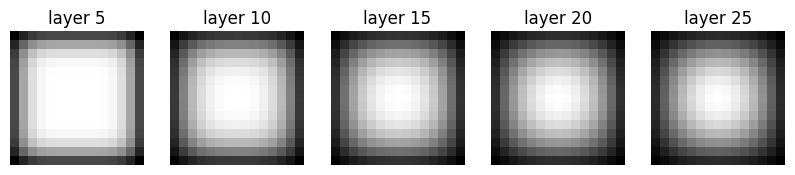

In [22]:
# create a 15x15 input filled with ones
x = torch.ones(1, 1, 15, 15)

# create a 3x3 convolution
conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1, 1))

# set weights to 1/9 (= sum to one), bias to zero
conv.weight.data = torch.ones_like(conv.weight.data) / 9
conv.bias.data = torch.zeros_like(conv.bias.data)

plt.figure(figsize=(10, 2))
for n in range(1, 26):
    # apply another convolution
    x = conv(x)
    # print('layer %d, output size: %dx%d' % (n + 1, x.shape[2], x.shape[3]))
    if n % 5 == 0:
        plt.subplot(1, 5, n // 5)
        plt.imshow(x[0, 0].detach().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('layer %d' % n)

**(d) Explain the pattern that we see in the output of the final layers. How does this happen, and what does this mean for our very deep networks?<span style="float:right"> (2 points)</span>**

## 3.5 Spoken digits dataset (4 points)

Time for some practical experiments. The d2l book uses a dataset of images as a running example (FashionMNIST). In this assignment we will investigate CNNs in a completely different domain: speech recognition.

The dataset we use is the free spoken digits dataset, which can be found on https://github.com/Jakobovski/free-spoken-digit-dataset. This dataset consists of the digits 0 to 9, spoken by different speakers. The data comes as .wav files.

**(a) Use the commands below (or a similar tool) to download the dataset. You can also use `git clone` to clone the repository mentioned above.**

In [23]:
#! mkdir -p free-spoken-digit-dataset
#! wget -O - https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.tar.gz | tar xzv -C free-spoken-digit-dataset --strip-components=1

In [24]:
samplerate = 8000


def load_waveform(file, size=6000):
    samplerate, waveform = wavfile.read(file)
    # Take first 6000 samples from waveform. With a samplerate of 8000 that corresponds to 3/4 second
    # Pad with 0s if the file is shorter
    waveform = np.pad(waveform, (0, size))[0:size]
    # Normalize waveform
    waveform = (waveform - np.mean(waveform)).astype(int)
    waveform = (waveform / np.std(waveform)).astype(int)
    return waveform

The following code loads all .wav files in a directory, and makes it available in a pytorch dataset.

**(c) Load the data into a variable `data`.**

**(d) Describe the dataset: how many samples are there, how many features does each sample have? How many classes are there?<span style="float:right"> (1 point)</span>**

In [26]:
print(f"There are {len(data)} samples and {data[0][0].shape[1]} features per sample and ten classes")

There are 3000 samples and 6000 features per sample and ten classes


In [27]:
from IPython.display import Audio


def play(sample):
    print(f'Label: {sample[1]}')
    return Audio(sample[0][0].numpy(), rate=samplerate)


play(data[0])

Label: 6


Before continuing, we split the dataset into a training and a test set.

The code above uses 2/3 of the data for training.

**(e) Discuss an advantage and disadvantage of using more of the data for training.<span style="float:right"> (2 points)</span>**

- The more different training data you use, the more you reduce the change of overfitting.
- The more training data you have, the more accurate your network can become.
----
- Using more data for training, results in less data for validation, which increases the chance of not representing the real-world data properly.

In [29]:
data_params = {'batch_size': 32}
train_iter = torch.utils.data.DataLoader(train, **data_params)
test_iter = torch.utils.data.DataLoader(test, **data_params)

## 3.6 One-dimensional convolutional neural network (8 points)

In [30]:
def build_net():
    return torch.nn.Sequential(
        nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(11872, 128), nn.ReLU(),
        nn.Linear(128, 64), nn.ReLU(),
        nn.Linear(64, 10))

**(b) The first fully connected layer has input dimension 11872, where does that number come from?<span style="float:right"> (1 point)</span>**

Hint: think about how (valid) convolutional layers and pooling layers with stride affect the size of the data.

**(c) How many parameters are there in the model? I.e. the total number of weights and biases.<span style="float:right"> (1 point)</span>**

**(d) Suppose that instead of using convolutions, we had used only fully connected layers, while keeping the number of features on each hidden layer the same. How many parameters would be needed in that case approximately?<span style="float:right"> (1 point)</span>**

In [33]:
(6000 ** 2 + 6000) * 4

144024000

The FashionMNIST dataset used in the book has 60000 training examples. How large is our training set? How would the difference affect the number of epochs that we need? Compare to [chapter 7.6](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html) and [chapter 8.1](http://d2l.ai/chapter_convolutional-modern/alexnet.html) of the book.

**(e) How many epochs do you think are needed?<span style="float:right"> (1 point)</span>**

In [34]:
lr, num_epochs = 0.01, 30

In [35]:
def train(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device, torch.long)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

**(f) Now train the network.**

**(g) Did the training converge?<span style="float:right"> (2 point)</span>**

**If the training has not converged, maybe you need to change the number of epochs and/or the learning rate.**

Hint: This is a non-trivial problem, so your network might take some time to
learn. Don't give up too quickly, it might take 50-100 epochs before you
see any significant changes in the loss curves.


| Experiment   | epochs | lr   | train accuracy | test accuracy | converged? |
|--------------|--------|------|----------------|---------------|------------|
| experiment 1 | 75     | 0.02 | 1              | 0.438         | yes        |
| experiment 2 | 150    | 0.02 | 1              | 0.647         | yes        |

## 3.7 Questions and evaluation (6 points)

The network does not underfit. We do not see any signs of overfitting either, but we cannot be completely sure, as we don't see the training loss.

**(b) Is what we have here a good classifier? Could it be used in a realistic application? Motivate your answer.<span style="float:right"> (1 point)</span>**

**(c) Do you think there is enough training data compared to the dimensions of the data and the number of parameters? Motivate your answer.<span style="float:right"> (1 point)</span>**

No, it does not seem like that. Compared to the image classification of last exercise, we do have 15 times more network params but only twice as many training samples. Additionally, we have about 7.5 times more features per sample.

The network has way too many features and parameters compared to the size of the training set.

1. More training data
2. Tuning the network architecture
3. Augmented training data

**(e) The free spoken digits datasets has recordings from several different speakers. Is the test set accuracy a good measure of how well the trained network would perform for recognizing digits spoken by a new, unknown speaker? And if not, how could that be tested instead?<span style="float:right"> (2 points)</span>**

## 3.8 Variations (8 points)

One way in which the training might be improved is with dropout or with batch normalization.

**(a) Make a copy of the network architecture from 3.6a below, and add dropout.<span style="float:right"> (1 point)</span>**

Hint: see [chapter 8.1](http://d2l.ai/chapter_convolutional-modern/alexnet.html#architecture) for an example that uses dropout.

loss 0.134, train acc 0.957, test acc 0.651
5162.4 examples/sec on cuda:0


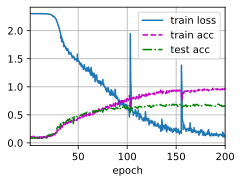

In [37]:
def build_net_dropout():
    return torch.nn.Sequential(
        nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(11872, 128), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(64, 10))


train(build_net_dropout(), train_iter, test_iter, num_epochs=200, lr=0.02)

- The training loss does not go down that quickly and does not reach 0.
- The training acc does not reach 1 and also does not increase as quickly.

**(c) Make a copy of the original network architecture, and add batch normalization to all convolutional and linear layers.<span style="float:right"> (1 point)</span>**

Hint: see [chapter 8.5](http://d2l.ai/chapter_convolutional-modern/batch-norm.html#concise-implementation) for an example.

**(d) How does batch normalization change the results? Does this match what you saw on the simple network last week?<span style="float:right"> (1 point)</span>**

The training converges a lot faster and the training loss, as well as the test accuracy are much better.

The improvement is much bigger than on the simple network of last week.

In [39]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""

    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv1d(num_channels, kernel_size=5, padding=2,
                                   stride=strides)
        self.conv2 = nn.LazyConv1d(num_channels, kernel_size=5, padding=2)

        if use_1x1conv:
            self.conv3 = nn.LazyConv1d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.LazyBatchNorm1d()
        self.bn2 = nn.LazyBatchNorm1d()

    def forward(self, X):
        Y = nn.functional.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return nn.functional.relu(Y)

**(f) Make a copy of the network architecture from 3.6a, and replace the convolutions with residual blocks.<span style="float:right"> (1 point)</span>**

**(g) How do residual connections change the results?<span style="float:right"> (1 point)</span>**

Using the residual connections slows down the convergence speed, but significantly improves the train loss, and the train and test accuracy. By now, we have a test accuracy of nearly 90%.

In [41]:
from python_speech_features import mfcc


def load_waveform_mfcc(file, size=6000):
    samplerate, waveform = wavfile.read(file)
    waveform = np.pad(waveform, (0, size))[0:size] / 32768
    return np.transpose(mfcc(waveform, samplerate))

**(a) Implement a variation of the dataset that uses these features.<span style="float:right"> (2 points)</span>**

The MFCC features will have 13 channels instead of 1 (the `unsqueeze` operation is not needed). 

**(b) Inspect the shape of the data, and define a new network architecture that accepts data with this shape.<span style="float:right"> (1 point)</span>**

In [43]:
def build_net_mfcc():
    return torch.nn.Sequential(
        Residual(16, use_1x1conv=True),
        nn.AvgPool1d(kernel_size=2, stride=2),

        Residual(32, use_1x1conv=True),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(48000, 128), nn.ReLU(),
        nn.Linear(128, 64), nn.ReLU(),
        nn.Linear(64, 10))

loss 0.005, train acc 1.000, test acc 0.689
2079.9 examples/sec on cuda:0


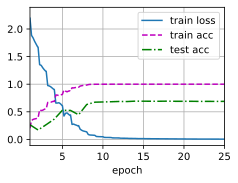

In [44]:
train(build_net_mfcc(), train_iter, test_iter, num_epochs=25, lr=0.01)

**(d) What would be needed to get a fully neural network approach to work as well as MFCC features?<span style="float:right"> (1 point)</span>**

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 57 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 6717cb8 / 2023-09-15</span>